### This script takes an amount of labeled pdf files, and extracts the relative_non_white value for each segmented box, to get the perfect threshold for the applied segmentation and preprocessing

In [13]:
import utils

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

In [30]:
BASE_PATH='C:\\Uni\\1M. Semester\\DocDig\\gen_img'      # Path whith the scan folders (which contain a cell folder and a Gelabelt.xlsx
SCANS=['scan_1972_CdB_3_20231125160810.pdf', 'scan_1972_CdB_10_20231125162253.pdf']            # Scans that should be included to the threshold analysis

scan_paths = [os.path.join(BASE_PATH, scan) for scan in SCANS]

In [31]:
# Regex pattern to match files like 125160810Gelabelt.xlsx (The labels)
pattern = re.compile(r'^\d+Gelabelt\.xlsx$')

label_paths = []

for scan in scan_paths:
    
    # Check if it is a folder
    if not os.path.exists(scan):
        print(f"This path does not exist: {scan}")
        
    # Search the label excel file
    if os.path.isdir(scan):
        found_file = False # Flag to track if the file was found
        for file in os.listdir(scan):
            if pattern.match(file):
                full_path = os.path.join(scan, file)
                label_paths.append(full_path)
                found_file = True
                break
        # If the file is not found, print an error message
        if not found_file:
            print(f"Error: No matching Gelabelt.xlsx file found in folder '{scan}'.")
            scan_paths.remove(scan)     # Remove this folder, as it has no labels and therefore cant be used for the threshold analysis

Error: No matching Gelabelt.xlsx file found in folder 'C:\Uni\1M. Semester\DocDig\gen_img\scan_1972_CdB_10_20231125162253.pdf'.


In [32]:
### Get all labels into a list

# Initialize a list to store labels for each sheet
label_list = []

for labels in label_paths:
    excel_data = pd.read_excel(labels, sheet_name=None, header=None, dtype=str)

    temp_label_list = []

    # Iterate through each sheet in the Excel file
    for sheet_name, df in excel_data.items():
        # Extract the first 50 lines from the second column (column 'B')
        labels = df.iloc[:50, 1]  # Get the first 50 rows of column B
    
        # Replace NaN values (empty cells) with empty strings
        labels = labels.fillna('')
    
        # Append the labels as a list for this sheet, preserving all values
        temp_label_list.append(labels.values)
    label_list.append(temp_label_list)

label_list = np.array(label_list)
print(label_list)
print(label_list.shape)

[[['Mehlschwalbe' '"' '"' ... '"' '"' '"']
  ['Tannenmeise' '"' '' ... '"' '"' '"']
  ['Tannenmeise' '' '' ... '"' '"' '"']
  ...
  ['Mésange bleue' 'Mésange noire' 'Mésange bleue' ... '"' '"' '"']
  ['Trauerschnäpper' '"' '"' ... 'Fitis' 'Gartenrötel' 'Trauerschnäpper']
  ['Trauerschnäpper' '"' 'Gartenrötel' ... '"' '"' '"']]]
(1, 23, 50)


In [39]:
image_folder = "cells\\NOPRE-COLOR-col-1"

QuotationMarkRelativeNonWhites = []
TextRelativeNonWhites = []

# Loop over all pdf files
for i, scan in enumerate(scan_paths):
    # Loop over all pages in this pdf file
    for page in range(len(label_list[0])):
        # Loop over all lines of this page
        for line in range(50):
            filename = str(page) + "-" + str(line+2) + ".png"
            
            label = label_list[i][page][line]
            
            # Construct the full path to image segment
            file_path = os.path.join(scan, image_folder, filename)
            if not os.path.exists(file_path):
                print(f"Something went wrong!!! {file_path} is not a file!!! .isfile: {os.path.isfile(file_path)}")
                break   # if something went wrong here, it usually is because of wrong segmentation ---> should be fixed with benedikts new segmentation
                #Todo: Implement upgraded segmentation in this process
            
            # Check if the file is an image (add more extensions if needed)
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                try:
                    # Load and process the image
                    image_original = cv2.imread(file_path)
                    
                    tmp = utils.detectQuotationMarks(image_original)
                    
                    # Check if true label is a quotationmark or a text and append the relative value to list for later plotting
                    if label == '"' or label == '':
                        QuotationMarkRelativeNonWhites.append(tmp['relativeNonWhite'])
                    else:
                        TextRelativeNonWhites.append(tmp['relativeNonWhite'])
                        
                    
                except Exception as e:
                    print(f"Error processing file {filename}: {e}")

Something went wrong!!! C:\Uni\1M. Semester\DocDig\gen_img\scan_1972_CdB_3_20231125160810.pdf\cells\NOPRE-COLOR-col-1\14-51.png is not a file!!! .isfile: False
Something went wrong!!! C:\Uni\1M. Semester\DocDig\gen_img\scan_1972_CdB_3_20231125160810.pdf\cells\NOPRE-COLOR-col-1\18-39.png is not a file!!! .isfile: False



RESULTS FOR Quotationmarks:
Mean: 0.0785, Median: 0.0746, Quantiles (85, 90, 95): (0.0882, 0.0936, 0.1201), Minimum: 0.0029, Maximum: 0.2875

RESULTS FOR Text:
Mean: 0.1422, Median: 0.1416, Quantiles (1, 2, 3, 4, 5, 10): (0.0790), 0.0925), 0.0970),, 0.1040) 0.1062, 0.1142, Minimum: 0.0713, Maximum: 0.3083


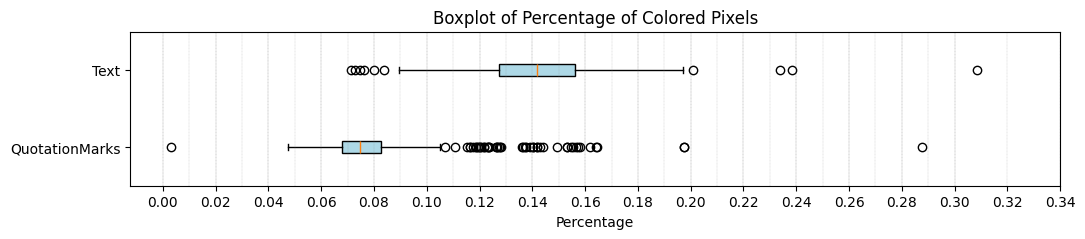

In [50]:
# Quotationmarks
print("\nRESULTS FOR Quotationmarks:")
print(f"Mean: {np.mean(QuotationMarkRelativeNonWhites):.4f}, Median: {np.median(QuotationMarkRelativeNonWhites):.4f}, Quantiles (85, 90, 95): ({np.quantile(QuotationMarkRelativeNonWhites, 0.85):.4f}, {np.quantile(QuotationMarkRelativeNonWhites, 0.90):.4f}, {np.quantile(QuotationMarkRelativeNonWhites, 0.95):.4f}), Minimum: {np.min(QuotationMarkRelativeNonWhites):.4f}, Maximum: {np.max(QuotationMarkRelativeNonWhites):.4f}")

# Text
print("\nRESULTS FOR Text:")
print(f"Mean: {np.mean(TextRelativeNonWhites):.4f}, Median: {np.median(TextRelativeNonWhites):.4f}, Quantiles (1, 2, 3, 4, 5, 10): ({np.quantile(TextRelativeNonWhites, 0.01):.4f}), {np.quantile(TextRelativeNonWhites, 0.02):.4f}), {np.quantile(TextRelativeNonWhites, 0.03):.4f}),, {np.quantile(TextRelativeNonWhites, 0.04):.4f}) {np.quantile(TextRelativeNonWhites, 0.05):.4f}, {np.quantile(TextRelativeNonWhites, 0.10):.4f}, Minimum: {np.min(TextRelativeNonWhites):.4f}, Maximum: {np.max(TextRelativeNonWhites):.4f}")


plt.figure(figsize=(12, 2))
plt.boxplot([QuotationMarkRelativeNonWhites, TextRelativeNonWhites], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Add labels and title
plt.title('Boxplot of Percentage of Colored Pixels')
plt.xlabel('Percentage')
plt.yticks([1, 2], ['QuotationMarks', 'Text'])

# Add a light grid with lines at every 0.01 on the x-axis
plt.grid(axis='x', color='gray', linestyle='--', linewidth=0.2, alpha=0.7)

# Add gridlines for every 0.01
plt.xticks(ticks=[i * 0.02 for i in range(0, 18)],  # Show every second tick (0.00, 0.02, ...)
           labels=[f'{i * 0.02:.2f}' for i in range(0, 18)])  # Format as 0.00, 0.02, etc.

# Manually add the gridlines at every 0.01
for x in [i * 0.01 for i in range(0, 31)]:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.2, alpha=0.7)
    
# Display the plot
plt.show()